<a href="https://colab.research.google.com/github/amswanson333/pml-yolo/blob/main/yolo_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preamble

In [1]:
a=!python --version

print(f"current python is {a}")

import sklearn
print(f"current sklearn is {sklearn.__version__}")

import keras;
print(f"current keras is {keras.__version__}")

import seaborn
print(f"seaborn version {seaborn.__version__}")

import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values
try:
  print(get_gpu_memory())
except:
  print("bruh, no gpu")

current python is ['Python 3.11.13']
current sklearn is 1.6.1
current keras is 3.8.0
seaborn version 0.13.2
[40506]


Current versions (8 Jun 25)
```
current python is ['Python 3.11.13']
current sklearn is 1.6.1
current keras is 3.8.0
seaborn version 0.13.2
```

Previous versions (2022)
```
current python is ['Python 3.7.13']
current sklearn is 1.0.2
current keras is 2.8.0
```

Installs Ultralytics and Ultralytics HUB packages

First run will require a restart of the runtime on colab, run a second time to confirm install

In [2]:
%pip install ultralytics  # install
%pip install hub-sdk
from ultralytics import YOLO, checks, hub
checks()  # checks

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.5/235.7 GB disk)


Used to connect to the Ultralytics HUB, has no specific use/benefit presently

In [4]:
# from hub_sdk import HUBClient

# api_key = "22a357d8a17b81ad56b0694053e85c1f25cf6612e0"

# credentials = {"api_key": api_key}
# client = HUBClient(credentials)
# client.login(api_key)

## Drives and file setups

In [3]:
import os
import csv
from google.colab import files, drive
import pandas as pd
import matplotlib.pyplot as plt

Set up drive location variables

Expected drive layout is:
```
content/
├─ fakeplanes/
│  ├─ predict/
│  ├─ test/
│  ├─ train/
│  ├─ val/
│  ├─ {project_name}/
│  │  ├─ training_results/
│  │  │  ├─ weights/
│  │  │  │  ├─ best.pt
│  │  │  │  ├─ last.pt
│  │  │  ├─ results.csv
│  ├─ fakeplanes.zip
│  ├─ fakeplanes_session.yaml
├─ gdrive/
│  ├─ MyDrive/
│  │  ├─ Colab/
│  │  │  ├─ fakeplanes/
│  │  │  │  ├─ datasets/
│  │  │  │  │  ├─ predict/
│  │  │  │  │  ├─ test/
│  │  │  │  │  ├─ train/
│  │  │  │  │  ├─ val/

```
Some of these files are created at later steps, e.g., `fakeplanes.zip` is created after the model is trained.

`gdrive/` layout is based on the currently used google drive and may change depending on the structure of the user's google drive. Either change the drive to match this format, or change the variables below to match the existing drive layout.

In [4]:
# Drive location variables
base_gdrive = '/content/gdrive'
base_wdir = '/content/fakeplanes'

# Data source path relative to base_gdrive
data_path = 'MyDrive/Colab/fakeplanes/datasets'

# These are relative file paths due to duplication in directory
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'
predict_folder = 'predict'
project_name = 'fakeplanes_3_class'
results_folder = 'training_results'

Mount the google drive to: `base_gdrive`

In [5]:
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


Copies the datasets from the google drive to the colab runtime session

Run time varies, roughly 6 - 12 minutes.

In [6]:
import time
start_time = time.time()

#copy to session RAM.  Takes 6 minutes for fakeplanes
import shutil
import os

source_path = os.path.join(base_gdrive, data_path)
destination_path = base_wdir

# Copy the entire directory from Google Drive to Colab's RAM
shutil.copytree(source_path,destination_path)

print(f'Dataset copied from {source_path} to {destination_path}')

print(f"--- {(time.time() - start_time)/60} minutes to run---")

Dataset copied from /content/gdrive/MyDrive/Colab/fakeplanes/datasets to /content/fakeplanes
--- 6.663538491725921 minutes to run---


## Training

Creates the `.yaml` file for the model training parameters

In [7]:
yaml_filename = 'fakeplanes_session.yaml'

# Update YAML file with the new path
yaml_content = f"""path: {base_wdir}/  # dataset root dir (leave empty for HUB)
train: {train_folder}  # train images (relative to 'path')
val:   {val_folder}    # val images (relative to 'path')
test:  {test_folder}   # test images (optional)

names:
  0: bomber
  1: fighter
  2: cargo
"""

# Write the updated YAML content to a new file
yaml_file_path = os.path.join(base_wdir, yaml_filename)

with open(yaml_file_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

print(f'Updated YAML file saved at {yaml_file_path}')

Updated YAML file saved at /content/fakeplanes/fakeplanes_session.yaml


Trains the YOLOv8x model on the training data set

Takes approximately 3.8 hours when using A100 GPU on Colab

In [8]:
import time
start_time = time.time()

import subprocess as sp
import os
import csv
from google.colab import files, drive
import pandas as pd
import matplotlib.pyplot as plt

print("-----------------------------------")
print("   Training on 4000 images ")
print("-----------------------------------")

# Note paths for model training are specified in the yaml
# Move to the base working directory
os.chdir(base_wdir)

# Load the YOLO model
model = YOLO('yolov8x.pt')  # Pre-trained YOLOv8 model  extra large

# Train the model on your custom dataset
model.train(data=yaml_filename,
            epochs=240,
            imgsz=640,
            name=results_folder,
            batch=0.85,
            # cache="ram",
            project = project_name,
            patience=20,
            exist_ok = True,  # ok to overwrite
            # fraction = 0.3,   # only use 30% of dataset for training
            plots=True,       # save metrics plots
            )


print(f"--- {(time.time() - start_time)/60} minutes to run---")

-----------------------------------
   Training on 4000 images 
-----------------------------------


100%|██████████| 131M/131M [00:00<00:00, 247MB/s]


Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=0.85, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fakeplanes_session.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=240, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_results, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose

100%|██████████| 755k/755k [00:00<00:00, 135MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           


  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  3   1948800  ultralytics.nn.modules.block.C2f             [960,

100%|██████████| 5.35M/5.35M [00:00<00:00, 443MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2768.6±1730.4 MB/s, size: 580.2 KB)


train: Scanning /content/fakeplanes/train... 3900 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3901/3901 [00:06<00:00, 628.48it/s]

train: New cache created: /content/fakeplanes/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 85.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA A100-SXM4-40GB) 39.56G total, 0.60G reserved, 0.57G allocated, 38.39G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    68155497       258.1         3.590         52.89         226.5        (1, 3, 640, 640)                    list
    68155497       516.3         4.828         45.57         108.1        (2, 3, 640, 640)                    list
    68155497        1033         6.619          49.5         106.2        (4, 3, 640, 640)                    list
    68155497        2065        10.108          52.3         111.5        (8, 3, 640, 640)                    list
    68155497        41

train: Scanning /content/fakeplanes/train.cache... 3900 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3901/3901 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1607.3±938.3 MB/s, size: 581.1 KB)


val: Scanning /content/fakeplanes/val... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:02<00:00, 503.24it/s]


val: New cache created: /content/fakeplanes/val.cache
Plotting labels to 3 class run A100/train_results/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.000546875), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to 3 class run A100/train_results
Starting training for 240 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/240      24.9G      1.413        1.6      1.293        181        640: 100%|██████████| 112/112 [00:50<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


                   all       1300       7130      0.852      0.772      0.845      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/240      24.1G      1.119     0.8174        1.1        126        640: 100%|██████████| 112/112 [00:49<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.921      0.834      0.894      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/240      24.5G     0.9997     0.7669      1.069        157        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]

                   all       1300       7130      0.886      0.728      0.801      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/240      24.5G     0.9987     0.7644      1.074        105        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.931      0.808      0.876      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/240      24.5G     0.9674     0.7408      1.047        115        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130       0.92      0.704      0.773      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/240      24.6G     0.9319     0.7034      1.043        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.938      0.795      0.853      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/240      24.5G     0.8858     0.6381      1.018         84        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.949      0.849      0.909       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/240      24.5G     0.8711     0.6252      1.011        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.959      0.866      0.921      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/240      24.5G     0.8471     0.6103      1.008        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.961      0.886      0.931      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/240      24.6G     0.8277     0.5937     0.9923         81        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.966      0.865      0.922      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/240      24.5G     0.8084     0.5688     0.9837        141        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.963      0.874      0.926      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/240      24.6G     0.7951     0.5536     0.9792        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130       0.97      0.888      0.932      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/240      24.5G     0.7877     0.5536     0.9783        141        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.967      0.894      0.937      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/240      24.4G     0.7735     0.5417     0.9716        127        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.974      0.902      0.948      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/240      24.5G      0.761     0.5236     0.9631        190        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.966      0.895       0.94      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/240      24.4G     0.7538     0.5193     0.9579        138        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.968      0.904      0.946      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/240      24.4G     0.7395     0.5116     0.9609        147        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.972      0.896      0.938      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/240      24.5G     0.7318     0.4963     0.9535        123        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.975      0.877      0.926      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/240      24.4G     0.7285     0.4877     0.9496        127        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.975      0.912      0.951      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/240      24.5G     0.7213     0.4913     0.9484         88        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.973       0.91       0.95      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/240      24.6G     0.7111     0.4827     0.9407        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.977      0.909      0.951      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/240      24.6G     0.7053     0.4706     0.9408        200        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.975      0.894      0.938       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/240      24.5G     0.7028       0.47     0.9405        116        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.983      0.915      0.957      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/240      24.6G     0.6951     0.4634     0.9431        104        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.979      0.916      0.955      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/240      24.4G     0.6892     0.4569     0.9385        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.975      0.916      0.954      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/240      24.6G     0.6759     0.4484     0.9316        163        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.982      0.919      0.958      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/240      24.5G     0.6716     0.4457     0.9353        131        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.978      0.916      0.955      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/240      24.4G     0.6771     0.4502     0.9342        136        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.983      0.916      0.958      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/240      24.5G     0.6678     0.4431     0.9286        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.978      0.918      0.957      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/240      24.5G     0.6576     0.4344     0.9246        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]

                   all       1300       7130      0.979      0.925       0.96      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/240      24.5G     0.6509     0.4281     0.9196        160        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.981      0.926       0.96      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/240      24.5G     0.6505     0.4305     0.9198        153        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]

                   all       1300       7130      0.982      0.925      0.961      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/240      24.5G      0.641     0.4211     0.9178        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.983      0.926      0.962      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/240      24.5G     0.6381     0.4187     0.9178        121        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]

                   all       1300       7130      0.976       0.93      0.963      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/240      24.5G     0.6405     0.4204     0.9148        146        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.978      0.922      0.958      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/240      24.4G     0.6327     0.4133     0.9128        120        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.979      0.927      0.962      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/240      24.5G     0.6335     0.4137     0.9147        158        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.984      0.927      0.961      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/240      24.4G     0.6204     0.4085     0.9105        101        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.983      0.934      0.966       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/240      24.6G     0.6187     0.4011     0.9099        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.984       0.92      0.956      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/240      24.5G     0.6175     0.4024     0.9146        124        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.988      0.933      0.967      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/240      24.5G      0.608     0.3956       0.91        181        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.984      0.935      0.966      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/240      24.5G     0.6077     0.3934     0.9035        126        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.985      0.926      0.957      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/240      24.6G     0.6065     0.3959     0.9064         89        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.985      0.936      0.965      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/240      24.4G     0.6078     0.3922     0.9036        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.987      0.937      0.967      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/240      24.5G     0.6016     0.3871     0.9008        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.986      0.935      0.967      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/240      24.6G     0.6012     0.3882     0.9072         99        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.986      0.935      0.968      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/240      24.6G     0.6039     0.3907     0.9004        145        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.987      0.931      0.965      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/240      24.5G     0.5978     0.3841     0.8997        108        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.986      0.939      0.967       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/240      24.4G      0.595     0.3825     0.9017        109        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.985      0.937      0.966      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/240      24.5G     0.5811     0.3714      0.896        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.988      0.928      0.963      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/240      24.5G     0.5876     0.3774     0.8974        123        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.934      0.969      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/240      24.5G     0.5881     0.3769      0.894        145        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.986      0.939      0.968      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/240      24.5G     0.5721     0.3605     0.8894        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.989      0.936      0.968      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/240      24.5G     0.5786     0.3706     0.8944        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.987      0.935       0.97      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/240      24.4G     0.5725     0.3655     0.8911        145        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130       0.99      0.936      0.969      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/240      24.6G     0.5744     0.3624     0.8914        114        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.988      0.936      0.969      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/240      24.4G     0.5701     0.3645     0.8863        112        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130       0.99      0.936       0.97      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/240      24.5G      0.565     0.3569     0.8882        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.985      0.938      0.969       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/240      24.5G      0.561     0.3554     0.8907        109        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.985      0.942      0.969      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/240      24.4G     0.5619     0.3567     0.8885        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.986      0.943       0.97      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/240      24.5G     0.5562     0.3509     0.8854         90        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.986      0.939       0.97       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/240      24.6G     0.5527     0.3512     0.8837        149        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.988       0.94       0.97      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/240      24.5G     0.5493     0.3466     0.8863        111        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.988      0.939      0.969      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/240      24.5G     0.5525     0.3487     0.8848        121        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130       0.99      0.941       0.97      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/240      24.5G     0.5557     0.3538     0.8816        133        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.987      0.943       0.97       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/240      24.5G     0.5473     0.3432     0.8805        147        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.986      0.943       0.97      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/240      24.4G     0.5531     0.3493     0.8833        124        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130       0.99       0.94       0.97      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/240      24.4G     0.5447     0.3434     0.8794        124        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130       0.99      0.938      0.968      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/240      24.5G     0.5457     0.3441     0.8792        143        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.989      0.943       0.97      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/240      24.4G     0.5495     0.3482     0.8785        122        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130       0.99      0.944       0.97      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/240      24.5G     0.5415     0.3418     0.8792        111        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130       0.99       0.94       0.97      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/240      24.6G     0.5399     0.3411     0.8758        146        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.937       0.97      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/240      24.5G     0.5308     0.3332     0.8757        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130       0.99      0.944      0.972      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/240      24.5G     0.5337     0.3325     0.8737        160        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.989      0.942      0.971      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/240      24.5G     0.5272     0.3329     0.8752        129        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.989      0.943      0.971      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/240      24.6G     0.5335     0.3353     0.8798         78        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.988      0.944       0.97      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/240      24.6G     0.5262     0.3315      0.875        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.988      0.946       0.97      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/240      24.5G     0.5319      0.333      0.877        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]

                   all       1300       7130      0.992      0.943      0.971      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/240      24.6G     0.5273     0.3316     0.8755         84        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.986      0.948      0.972      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/240      24.5G     0.5269     0.3307      0.872        115        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.989      0.947      0.973      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/240      24.6G     0.5227     0.3252     0.8663        102        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.989      0.946      0.972      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/240      24.5G     0.5194      0.323     0.8676        143        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.986      0.951      0.971      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/240      24.4G     0.5165     0.3222      0.868        143        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.989      0.947      0.974      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/240      24.4G     0.5152     0.3223     0.8704        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.946      0.972      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/240      24.3G     0.5218     0.3274     0.8723        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.946      0.973      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/240      24.4G     0.5091     0.3208     0.8651        120        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130       0.99      0.948      0.973      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/240      24.5G      0.505     0.3178      0.865        125        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130       0.99      0.946      0.974      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/240      24.4G      0.507     0.3154     0.8663        129        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.989      0.946      0.972      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/240      24.5G     0.5109     0.3183     0.8708        111        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130       0.99       0.95      0.974      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/240      24.5G      0.501      0.312     0.8622        141        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.992      0.947      0.974      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/240      24.5G     0.5055     0.3158     0.8705        113        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.947      0.973      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/240      24.5G     0.5019     0.3132     0.8649        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.994      0.948      0.974      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/240      24.5G       0.51     0.3172     0.8688        129        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.989       0.95      0.973      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/240      24.5G     0.4985     0.3082     0.8678        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991       0.95      0.973      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/240      24.5G     0.4968     0.3099     0.8656        182        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.992      0.947      0.973      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/240      24.5G     0.4927     0.3077     0.8673        136        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.993      0.947      0.973       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/240      24.5G     0.5007     0.3136      0.869        154        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.989      0.949      0.974      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/240      24.5G     0.4965     0.3074     0.8625        113        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.947      0.974      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/240      24.5G      0.491     0.3051     0.8612        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.952      0.975       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/240      24.5G     0.4932      0.304     0.8651        118        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.992      0.947      0.973      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/240      24.4G     0.4862     0.3018     0.8606        174        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.948      0.973      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/240      24.6G     0.4905     0.3048     0.8612        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.949      0.974      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/240      24.6G     0.4881     0.3008     0.8595        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.989      0.947      0.974      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/240      24.5G     0.4914     0.3055     0.8613        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130       0.99       0.95      0.975      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/240      24.5G     0.4797      0.292     0.8563        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.987      0.952      0.973       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/240      24.5G     0.4788     0.2961     0.8599        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.988      0.952      0.974      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/240      24.5G     0.4823     0.2968     0.8616        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.988      0.949      0.974      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/240      24.4G     0.4807     0.2969     0.8588        129        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.989      0.949      0.974      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/240      24.6G       0.48     0.2951     0.8602        108        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991       0.95      0.975      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/240      24.5G     0.4749     0.2892     0.8571        102        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.989      0.952      0.975      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/240      24.6G     0.4763     0.2941     0.8608        133        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.952      0.974      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/240      24.6G     0.4712     0.2908     0.8582         74        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.952      0.975      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/240      24.6G     0.4745     0.2928     0.8615        136        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.989      0.952      0.976      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/240      24.5G     0.4692     0.2882     0.8589        121        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130       0.99      0.951      0.974      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/240      24.6G     0.4702     0.2883     0.8547        104        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.948      0.976      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/240      24.5G     0.4716     0.2903     0.8575        103        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.989      0.952      0.975      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/240      24.5G     0.4682     0.2878     0.8564        147        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130       0.99      0.952      0.975      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/240      24.5G     0.4646     0.2869     0.8574        112        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.994      0.951      0.976      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/240      24.5G     0.4698     0.2901     0.8577        108        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.953      0.976      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/240      24.5G     0.4647     0.2851     0.8574        142        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.994       0.95      0.977      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/240      24.6G     0.4605     0.2843     0.8532        132        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130       0.99      0.951      0.977      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/240      24.4G      0.463     0.2857     0.8557        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.952      0.977      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/240      24.5G       0.46     0.2821      0.854        127        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.952      0.976      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/240      24.5G     0.4561     0.2825     0.8553        149        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.952      0.976      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/240      24.5G     0.4578     0.2778     0.8525        119        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994       0.95      0.977      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/240      24.5G     0.4566     0.2793      0.851        123        640: 100%|██████████| 112/112 [00:48<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.949      0.976      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/240      24.6G     0.4581     0.2806     0.8521        109        640: 100%|██████████| 112/112 [00:48<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.992      0.951      0.976      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/240      24.5G      0.454     0.2788     0.8556        107        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.953      0.976      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/240      24.5G     0.4513     0.2778     0.8542        137        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.994      0.951      0.976       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/240      24.5G     0.4481     0.2729     0.8514        189        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.992      0.954      0.977       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/240      24.5G     0.4501      0.275     0.8496        150        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.994      0.951      0.976      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/240      24.5G     0.4475     0.2736     0.8503        137        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.953      0.976      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/240      24.5G     0.4476     0.2756     0.8523        120        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.996      0.951      0.977       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/240      24.5G     0.4482     0.2723     0.8478        115        640: 100%|██████████| 112/112 [00:48<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.996      0.951      0.977       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/240      24.6G     0.4403     0.2674     0.8456        141        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.995      0.952      0.977      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/240      24.5G      0.445     0.2718     0.8496         94        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.995       0.95      0.977       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/240      24.5G     0.4485     0.2765     0.8505         75        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.953      0.977      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/240      24.4G      0.442     0.2693     0.8483        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.953      0.976      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/240      24.5G     0.4379     0.2685     0.8456         97        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.953      0.976       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/240      24.5G     0.4406     0.2686     0.8469        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]

                   all       1300       7130      0.992      0.952      0.977       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/240      24.5G     0.4332     0.2641     0.8438         92        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995       0.95      0.977      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/240      24.5G     0.4405     0.2694     0.8445        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.952      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/240      24.5G     0.4391     0.2701     0.8439        145        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.995      0.952      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/240      24.5G      0.432     0.2668     0.8438        142        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.955      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/240      24.6G     0.4284     0.2631     0.8434        175        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.953      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/240      24.5G     0.4269     0.2592     0.8441        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.955      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/240      24.6G     0.4272     0.2593     0.8426         84        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.952      0.978      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/240      24.4G     0.4286     0.2581     0.8428        153        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.09it/s]

                   all       1300       7130      0.994      0.954      0.978      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/240      24.5G     0.4303     0.2612     0.8431        123        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.992      0.955      0.977      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/240      24.5G     0.4252     0.2598     0.8413        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.956      0.977      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/240      24.4G     0.4287     0.2609     0.8436        118        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.954      0.977      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/240      24.5G     0.4227     0.2577     0.8386        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.996      0.953      0.977      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/240      24.5G     0.4201     0.2561     0.8397        158        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.994      0.954      0.977      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/240      24.5G     0.4168     0.2557       0.84        159        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.955      0.978      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/240      24.5G     0.4213     0.2568     0.8429        122        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.992      0.956      0.978      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/240      24.6G     0.4228     0.2588     0.8437        142        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.992      0.956      0.977      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/240      24.5G     0.4157     0.2511     0.8412        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.955      0.977      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/240      24.5G     0.4144      0.252     0.8428        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.994      0.953      0.977      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/240      24.5G     0.4119     0.2475     0.8403        107        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.993      0.954      0.977      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/240      24.4G     0.4117     0.2516     0.8417        137        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.994      0.954      0.978      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/240      24.5G     0.4114     0.2485      0.841        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.995      0.953      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/240      24.4G     0.4104     0.2472      0.838        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.996      0.952      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/240      24.5G     0.4131     0.2496     0.8398        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.996      0.952      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/240      24.5G     0.4086     0.2466     0.8394        106        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.994      0.954      0.978      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/240      24.6G     0.4077     0.2468     0.8384        125        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.955      0.978      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/240      24.4G     0.4028      0.245     0.8356        111        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.953      0.978      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/240      24.5G     0.4079     0.2473     0.8386        178        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.953      0.978      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/240      24.4G     0.4076     0.2477     0.8402         97        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.954      0.978      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/240      24.5G     0.4017     0.2443     0.8355        172        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.993      0.956      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/240      24.5G      0.399     0.2409     0.8361        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.955      0.977      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/240      24.5G     0.3956     0.2373     0.8371        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.994      0.954      0.977      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/240      24.5G     0.3975     0.2389      0.835        149        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.994      0.954      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/240      24.5G     0.4016     0.2422     0.8374        107        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.995      0.954      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/240      24.6G     0.3997     0.2426     0.8371        102        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.956      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/240      24.5G     0.3947      0.238     0.8363        103        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]

                   all       1300       7130      0.991      0.957      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/240      24.6G      0.393     0.2397     0.8326        151        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.955      0.978      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/240      24.5G     0.3905     0.2347     0.8326        107        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.955      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/240      24.6G     0.3924     0.2382     0.8326         98        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.994      0.954      0.978      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/240      24.5G     0.3848     0.2325      0.833        119        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.953      0.978      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/240      24.5G     0.3876     0.2342     0.8322        115        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.994      0.954      0.979      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/240      24.6G     0.3841     0.2314     0.8314        154        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]

                   all       1300       7130      0.993      0.955      0.979      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/240      24.5G     0.3816     0.2317     0.8321        118        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.09it/s]

                   all       1300       7130      0.994      0.953      0.979      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/240      24.5G     0.3824     0.2305     0.8304        122        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.956      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/240      24.5G     0.3829     0.2338     0.8351        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.09it/s]

                   all       1300       7130      0.994      0.953      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/240      24.4G     0.3808     0.2282     0.8296        151        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.952      0.978      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/240      24.5G     0.3846     0.2319     0.8315        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.953      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/240      24.4G     0.3753     0.2247     0.8292         87        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.993      0.954      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/240      24.5G     0.3726     0.2233     0.8276        158        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.993      0.955      0.978      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/240      24.4G      0.378     0.2274     0.8316        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.992      0.955      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/240      24.5G     0.3747     0.2243     0.8286        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.955      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/240      24.5G     0.3751     0.2254     0.8305        116        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.955      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/240      24.6G     0.3718     0.2231     0.8284        101        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.993      0.955      0.978      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/240      24.4G      0.371     0.2243     0.8288        126        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.955      0.978      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/240      24.6G     0.3707     0.2244      0.831        125        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.993      0.955      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/240      24.6G     0.3666     0.2205     0.8296        113        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]

                   all       1300       7130      0.991      0.957      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/240      24.6G     0.3715     0.2236     0.8303        159        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.992      0.956      0.977      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/240      24.4G     0.3676     0.2227     0.8282        125        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.956      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/240      24.5G      0.367     0.2201     0.8289        118        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]

                   all       1300       7130       0.99      0.958      0.978      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/240      24.5G     0.3612     0.2154     0.8273        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.991      0.958      0.978      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/240      24.5G     0.3621      0.217     0.8271        107        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.955      0.978      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/240      24.5G     0.3646     0.2198     0.8277         93        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130       0.99      0.958      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/240      24.4G     0.3598     0.2174     0.8274        122        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.995      0.953      0.979       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/240      24.5G     0.3595     0.2174     0.8285        149        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.995      0.953      0.979       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/240      24.6G     0.3555     0.2126     0.8246        148        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.954      0.979       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/240      24.5G     0.3561     0.2141     0.8245        121        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.996      0.953      0.979       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/240      24.5G     0.3601      0.215     0.8299        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.993      0.955      0.979       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/240      24.5G     0.3499     0.2108     0.8254        136        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.995      0.953      0.979       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/240      24.4G     0.3536     0.2135     0.8244        103        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.994      0.955      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/240      24.4G     0.3498     0.2096      0.821        137        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.994      0.955      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/240      24.4G     0.3488     0.2093     0.8239        129        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.954      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/240      24.5G     0.3517     0.2101     0.8233        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.995      0.953      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/240      24.4G     0.3483     0.2093     0.8252        132        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.995      0.954      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/240      24.4G      0.349     0.2106     0.8272        125        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.994      0.954      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/240      24.4G     0.3497      0.209     0.8244        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.991      0.957      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/240      24.5G      0.344     0.2058     0.8237        121        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.991      0.957      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/240      24.5G     0.3437     0.2057     0.8221        155        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.952      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/240      24.4G     0.3416     0.2061     0.8236        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130       0.99      0.957      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/240      24.4G      0.343     0.2051     0.8231        157        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.957      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/240      24.3G     0.3359     0.2026       0.82        126        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.957      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/240      24.5G     0.3383     0.2036     0.8221        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.991      0.957      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/240      24.5G     0.3377      0.202      0.821        131        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]

                   all       1300       7130      0.991      0.957      0.979      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/240      24.4G     0.3403     0.2046     0.8223        108        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.957      0.979      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/240      24.4G     0.3322     0.1982     0.8194        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.957      0.979      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/240      24.5G     0.3363     0.2025     0.8218        137        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.956      0.979      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/240      24.4G     0.3322     0.1995     0.8202        149        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.955      0.979      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/240      24.5G     0.3267     0.1961     0.8182        123        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.993      0.955      0.979      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/240      24.5G     0.3282     0.1976     0.8204         78        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.956      0.979      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/240      24.4G     0.3268     0.1962     0.8202        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.956      0.979      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/240      24.4G     0.3235     0.1958     0.8188        117        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.994      0.954      0.979      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/240      24.4G     0.3274     0.1948     0.8187        109        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all       1300       7130      0.994      0.954      0.979      0.931


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/240      24.5G     0.3288     0.1764     0.8071         85        640: 100%|██████████| 112/112 [00:49<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.995      0.954      0.979      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/240      24.5G     0.3144      0.171     0.8028         96        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.995      0.954      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/240      24.5G     0.3136       0.17     0.8049         80        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.995      0.954      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/240      24.5G     0.3078     0.1673      0.801         82        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.957      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/240      24.4G     0.3101     0.1678     0.8016         92        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.991      0.957      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/240      24.5G     0.3061     0.1651     0.8016         91        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.957      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/240      24.4G     0.3047     0.1651     0.7999         78        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.992      0.957      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/240      24.4G     0.3013     0.1627     0.7987         96        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.957      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/240      24.4G      0.301     0.1633     0.7993         89        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.992      0.956      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/240      24.5G     0.3005     0.1635     0.7991         84        640: 100%|██████████| 112/112 [00:47<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.955      0.978       0.93



240 epochs completed in 3.880 hours.
Optimizer stripped from 3 class run A100/train_results/weights/last.pt, 136.7MB
Optimizer stripped from 3 class run A100/train_results/weights/best.pt, 136.7MB

Validating 3 class run A100/train_results/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,126,457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]


                   all       1300       7130      0.995      0.954      0.978      0.932
                bomber        722       1128      0.996      0.968      0.988      0.975
               fighter       1131       3204      0.992      0.907      0.953      0.841
                 cargo       1090       2798      0.996      0.985      0.994      0.979
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to 3 class run A100/train_results
--- 233.67209436098736 minutes to run---


Zips and downloads the run data and model

In [9]:
import shutil
from google.colab import files

# Path to the folder you want to download
folder_path = os.path.join(base_wdir,project_name,results_folder)  # Change this to your folder path
zip_file_path = '/content/fakeplanes_results.zip'  # Location where the zip file will be saved

# Create a zip archive of the folder
shutil.make_archive('/content/fakeplanes_results', 'zip', folder_path)

# Download the zip file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loads the `results.csv` into a dataframe and displays

Each row is an Epoch, each column is the stats for that Epoch and a running time

In [10]:
df=pd.read_csv(os.path.join(folder_path, 'results.csv'))
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,61.0878,1.41287,1.60044,1.29311,0.85228,0.77188,0.84477,0.59550,1.15245,0.82307,1.11222,0.003304,0.003304,0.003304
1,2,120.5280,1.11905,0.81742,1.10022,0.92096,0.83429,0.89438,0.68472,0.93828,0.59758,1.04245,0.006610,0.006610,0.006610
2,3,179.2980,0.99973,0.76691,1.06855,0.88596,0.72759,0.80085,0.60240,0.97044,0.96254,1.07563,0.009888,0.009888,0.009888
3,4,237.4420,0.99872,0.76435,1.07394,0.93138,0.80796,0.87571,0.68941,0.88414,0.63746,1.03328,0.009876,0.009876,0.009876
4,5,295.8740,0.96739,0.74077,1.04690,0.92039,0.70411,0.77297,0.60842,0.96170,0.83364,1.08392,0.009835,0.009835,0.009835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,236,13736.9000,0.30609,0.16511,0.80163,0.99161,0.95719,0.97847,0.93056,0.37469,0.20584,0.81576,0.000306,0.000306,0.000306
236,237,13794.8000,0.30471,0.16510,0.79991,0.99156,0.95717,0.97816,0.93049,0.37456,0.20561,0.81573,0.000265,0.000265,0.000265
237,238,13852.8000,0.30131,0.16270,0.79871,0.99190,0.95664,0.97829,0.93060,0.37441,0.20555,0.81567,0.000224,0.000224,0.000224
238,239,13910.8000,0.30105,0.16334,0.79934,0.99201,0.95608,0.97843,0.93071,0.37445,0.20539,0.81570,0.000182,0.000182,0.000182


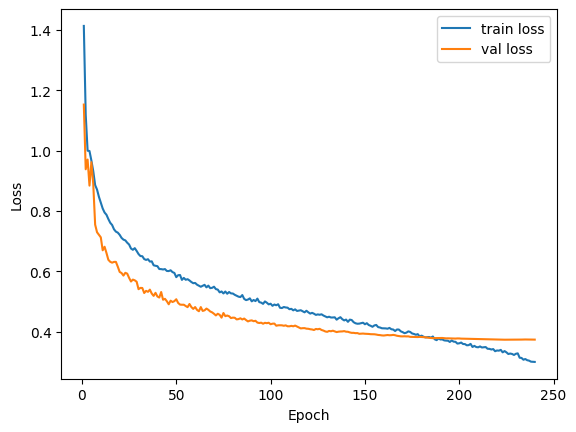

In [11]:
plt.plot(df.epoch, df["train/box_loss"],label='train loss')
plt.plot(df.epoch, df["val/box_loss"],label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
import time
start_time = time.time()

print("-----------------------------------")
print("   Validating on 1000 images to collect metrics")
print("-----------------------------------")

# Validate the model
validation_results = model.val(data=yaml_filename,
                    imgsz=640,  # Image size for validation
                    conf=0.5,  # Confidence threshold
                    iou=0.5,  # IoU threshold
                    device='0')  # Device to use (e.g., '0' for GPU, 'cpu' for CPU)

results = validation_results.results_dict

print("-----------------------------------")
print(results)
print("-----------------------------------")

precision = results['metrics/precision(B)']
recall = results['metrics/recall(B)']
mAP50 = results['metrics/mAP50(B)']
mAP5095 = results['metrics/mAP5095(B)']
fitness = results['fitness']

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"mAP50: {mAP50:.4f}")
print(f"mAP5095: {mAP5095:.4f}")
print(f"Fitness: {fitness:.4f}")

print(f"--- {(time.time() - start_time)} seconds to run---")

-----------------------------------
   Validating on 1000 images to collect metrics
-----------------------------------
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,126,457 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 2037.1±1134.2 MB/s, size: 297.1 KB)


val: Scanning /content/fakeplanes/val.cache... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.72it/s]


                   all       1300       7130      0.996      0.951      0.975      0.938
                bomber        722       1128      0.997      0.965      0.982      0.972
               fighter       1131       3204      0.994      0.905      0.952      0.862
                 cargo       1090       2798      0.997      0.982       0.99       0.98
Speed: 0.5ms preprocess, 5.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to 3 class run A100/train_results
-----------------------------------
{'metrics/precision(B)': np.float64(0.9961800888210419), 'metrics/recall(B)': np.float64(0.9506682395273414), 'metrics/mAP50(B)': np.float64(0.9748076590365455), 'metrics/mAP50-95(B)': np.float64(0.9380742996175464), 'fitness': np.float64(0.9417476355594463)}
-----------------------------------
--- 18.49886178970337 seconds to run---


Basic model accuracy metrics (dictionary):

In [13]:
results

{'metrics/precision(B)': np.float64(0.9961800888210419),
 'metrics/recall(B)': np.float64(0.9506682395273414),
 'metrics/mAP50(B)': np.float64(0.9748076590365455),
 'metrics/mAP50-95(B)': np.float64(0.9380742996175464),
 'fitness': np.float64(0.9417476355594463)}

ultralytics.utils.metrics.DetMetrics object results (very large JSON-like)

In [14]:
validation_results

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ac189af3350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Prediction

In [15]:
# Path for the trained model
trained_model = 'best.pt'
model_path = os.path.join(base_wdir, project_name, results_folder, 'weights', trained_model)

# Path for the predictions folder
predicts_path = os.path.join(base_wdir, predict_folder)

# Get a list of the different folders in the predict folder
predict_folders = [dir for dir in os.listdir(predicts_path)]

# Image extensions to allow for predictions
image_ext = ['.jpg', '.tif', '.png']

# Initialize model
model = YOLO(model_path)

results = []

for folder in predict_folders:
    folder_path = os.path.join(predicts_path, folder)
    for file in os.listdir(folder_path):
        if file.lower().endswith(tuple(image_ext)):
            file_path = os.path.join(folder_path, file)
            result = model.predict(file_path, visualize=True, conf=0.5, save=True)
            results.append(result[0])

for i in range(len(results)):
    image_output_path = os.path.join(base_wdir, 'three_class_output')  # this is on google drive
    results[i].save(f'{image_output_path}-{trained_model}-{images[i]}')


Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage0_Conv_features.png... (32/80)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage1_Conv_features.png... (32/160)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage2_C2f_features.png... (32/160)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage3_Conv_features.png... (32/320)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage4_C2f_features.png... (32/320)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage5_Conv_features.png... (32/640)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage6_C2f_features.png... (32/640)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage7_Conv_features.png

NameError: name 'trained_models' is not defined

## Regularization Techniques

Adding three different regularization techniques:
- Weight Decay (L2 regularization)
- Label smoothing
- Image data augmentation (built in YOLO filters)

Note: Epochs also reduced to 200 based on previous training loss chart

Completes in roughtly 3.2 hours on A100 GPU.

In [8]:
import time
start_time = time.time()

import subprocess as sp
import os
import csv
from google.colab import files, drive
import pandas as pd
import matplotlib.pyplot as plt

print("-----------------------------------")
print("   Training on 4000 images ")
print("-----------------------------------")

# Note paths for model training are specified in the yaml
# Move to the base working directory
os.chdir(base_wdir)

# Load the YOLO model
model = YOLO('yolov8x.pt')  # Pre-trained YOLOv8 model  extra large

# Train the model on your custom dataset
model.train(data=yaml_filename,
            epochs=200,
            imgsz=640,
            name=results_folder,
            batch=0.85,
            # cache="ram",
            project = project_name,
            patience=20,
            exist_ok = True,        # ok to overwrite
            # fraction = 0.3,       # only use 30% of dataset for training
            plots=True,             # save metrics plots
            weight_decay=0.001,     # L2 regularization
            label_smoothing=0.1,    # label smoothing
            augment=True,           # data augmentation for regularization
            )


print(f"--- {(time.time() - start_time)/60} minutes to run---")

-----------------------------------
   Training on 4000 images 
-----------------------------------


100%|██████████| 131M/131M [00:00<00:00, 284MB/s]


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=0.85, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fakeplanes_session.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training_results, nbs=64, nms=False, opset=None, optimize=False

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              


  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2912.3±1946.3 MB/s, size: 580.2 KB)


train: Scanning /content/fakeplanes/train... 3900 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3901/3901 [00:06<00:00, 623.43it/s]


train: New cache created: /content/fakeplanes/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 85.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA A100-SXM4-40GB) 39.56G total, 0.60G reserved, 0.57G allocated, 38.39G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    68155497       258.1         3.590         66.58         236.1        (1, 3, 640, 640)                    list
    68155497       516.3         4.828         45.72         108.5        (2, 3, 640, 640)                    list
    68155497        1033         6.619         50.76         105.3        (4, 3, 640, 640)                    list
    68155497        2065        10.108         53.71         110.2        (8, 3

train: Scanning /content/fakeplanes/train.cache... 3900 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3901/3901 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2314.0±1868.3 MB/s, size: 581.1 KB)


val: Scanning /content/fakeplanes/val... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:02<00:00, 512.17it/s]

val: New cache created: /content/fakeplanes/val.cache


Plotting labels to fakeplanes_3_class/training_results/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00109375), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to fakeplanes_3_class/training_results
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      24.9G      1.413      1.593      1.292        181        640: 100%|██████████| 112/112 [00:50<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


                   all       1300       7130      0.868      0.754      0.842      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      24.1G      1.107     0.8147      1.098        126        640: 100%|██████████| 112/112 [00:49<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.949      0.837       0.91      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      24.5G     0.9892     0.7423      1.059        157        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.01it/s]


                   all       1300       7130        0.9      0.745      0.817      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      24.5G      1.002     0.7782      1.071        105        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.05it/s]

                   all       1300       7130      0.894      0.725      0.804      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      24.4G     0.9744     0.7531      1.054        115        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.922      0.811      0.879      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      24.5G     0.9398     0.7125      1.048        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]

                   all       1300       7130      0.932      0.805      0.879      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      24.5G     0.8889     0.6502       1.02         84        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130       0.95      0.853      0.916      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      24.3G     0.8791     0.6354       1.02        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.953      0.843      0.906      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      24.4G     0.8513     0.6159       1.01        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.958      0.818      0.885      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      24.4G     0.8304     0.5941     0.9917         81        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.967      0.883      0.938      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      24.4G     0.8178     0.5692      0.986        141        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.967      0.887      0.933      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      24.3G     0.8018      0.563     0.9825        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.967      0.892      0.938      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      24.3G     0.7932     0.5532     0.9834        141        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.963      0.851       0.91      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      24.4G     0.7773     0.5434     0.9761        127        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.974      0.896      0.944      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      24.5G     0.7682     0.5289     0.9651        190        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.968      0.901      0.943      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      24.3G     0.7593      0.519     0.9656        138        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130       0.97      0.892      0.941      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      24.3G     0.7431     0.5139     0.9624        147        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.973      0.909      0.951      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      24.3G     0.7344     0.4975     0.9565        123        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.966      0.883      0.931       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      24.4G     0.7318     0.4933     0.9521        127        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130       0.97      0.909       0.95      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      24.4G     0.7232     0.4943     0.9491         88        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.976      0.907      0.953      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      24.4G      0.716     0.4883     0.9458        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.974      0.909      0.949      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      24.4G     0.7112     0.4802     0.9463        200        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.09it/s]

                   all       1300       7130      0.979      0.912      0.952      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      24.4G     0.7072     0.4747     0.9381        116        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.981      0.918      0.955      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      24.4G     0.7013      0.469     0.9397        104        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.978      0.914      0.956      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      24.3G     0.6928      0.464       0.94        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.977      0.915      0.953      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      24.4G     0.6806     0.4495     0.9338        163        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.978      0.926      0.959       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      24.4G      0.677     0.4532      0.936        131        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.986      0.909      0.957      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      24.4G     0.6818     0.4556     0.9344        136        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.979      0.923       0.96      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      24.4G     0.6733     0.4497     0.9352        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.981       0.92      0.958      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      24.4G     0.6652     0.4388     0.9303        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.983      0.924      0.962      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      24.4G     0.6592     0.4365     0.9281        160        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.975      0.921      0.959      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      24.5G     0.6566     0.4387     0.9224        153        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.984      0.922      0.959      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      24.4G     0.6462     0.4245     0.9205        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.979      0.926      0.962      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      24.4G      0.651     0.4267     0.9246        121        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.981      0.923       0.96      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      24.4G      0.645     0.4309     0.9176        146        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.983      0.907      0.951      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      24.5G     0.6408     0.4191     0.9152        120        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.987       0.92       0.96      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      24.5G     0.6432      0.421     0.9186        158        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.979      0.933      0.963      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      24.5G     0.6263     0.4123     0.9121        101        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.983      0.921      0.958      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      24.6G     0.6304     0.4099     0.9113        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.984      0.934      0.964      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      24.5G     0.6246     0.4065     0.9154        124        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.982      0.933      0.959      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      24.5G     0.6155     0.4013     0.9115        181        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.983      0.927      0.961      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      24.4G     0.6163     0.3965     0.9073        126        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.987       0.93      0.964      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      24.6G     0.6125     0.4002     0.9097         89        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.983      0.932      0.963      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      24.6G     0.6149     0.3995     0.9069        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.985       0.93      0.965      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      24.6G     0.6075     0.3944      0.906        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130       0.99      0.924      0.963      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      24.6G     0.6112      0.398      0.911         99        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.986      0.932      0.966      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      24.5G     0.6147     0.3997     0.9035        145        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.986       0.93      0.964      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      24.5G     0.6055     0.3942     0.9032        108        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.987      0.929      0.965      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      24.5G        0.6     0.3901      0.903        109        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130       0.99      0.932      0.967      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      24.4G      0.587      0.377      0.899        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.987      0.934      0.967      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      24.5G     0.5965     0.3864     0.8993        123        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.986      0.937      0.968      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      24.6G     0.5971      0.385     0.8969        145        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.983      0.937      0.965      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      24.6G     0.5801     0.3706     0.8913        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.986      0.938      0.969      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      24.6G     0.5828     0.3722     0.8964        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.984      0.937      0.966       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      24.5G     0.5811     0.3714     0.8954        145        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.987      0.935      0.966      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      24.6G      0.584      0.375     0.8962        114        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.986      0.934      0.968      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      24.5G     0.5779     0.3736     0.8897        112        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.984      0.942      0.969      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      24.6G     0.5722     0.3678     0.8936        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.932      0.967      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      24.5G     0.5705     0.3617      0.894        109        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.986      0.937      0.969      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      24.4G     0.5754     0.3685      0.894        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.983      0.941      0.967      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      24.5G     0.5676     0.3599     0.8914         90        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.988       0.94       0.97      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      24.4G     0.5668     0.3603      0.891        149        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130       0.99      0.938       0.97      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      24.4G     0.5628     0.3564     0.8931        111        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.984      0.943      0.971      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      24.4G     0.5623     0.3589     0.8906        121        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.987      0.939       0.97      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      24.5G     0.5628     0.3617     0.8871        133        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.988       0.94       0.97       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      24.5G     0.5578      0.353     0.8852        147        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.987      0.943      0.971      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      24.4G     0.5641     0.3604     0.8878        124        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130       0.99       0.94       0.97      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      24.4G     0.5536     0.3544     0.8861        124        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.989      0.942      0.971      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      24.6G     0.5535     0.3535     0.8857        143        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.944      0.972      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      24.5G      0.555      0.354     0.8858        122        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.991       0.94      0.972      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      24.4G     0.5486     0.3492     0.8854        111        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130       0.99      0.941      0.971      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      24.5G     0.5413     0.3445     0.8829        146        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.988      0.944      0.971      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      24.4G     0.5364     0.3407     0.8822        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.991      0.942      0.971      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      24.4G     0.5431     0.3417     0.8834        160        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.942      0.972      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      24.4G     0.5366     0.3415       0.88        129        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.984      0.945      0.972      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      24.4G     0.5413     0.3423     0.8831         78        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130       0.99      0.942      0.971      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      24.3G      0.539     0.3411     0.8784        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.987      0.946      0.972      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      24.4G     0.5407     0.3437     0.8779        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.944      0.972      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      24.4G     0.5355     0.3413     0.8775         84        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.988      0.945      0.973      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      24.5G     0.5325     0.3365     0.8781        115        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.993      0.942      0.972        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      24.5G       0.53     0.3339     0.8752        102        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.991      0.945      0.972        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      24.4G     0.5303     0.3326     0.8759        143        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.988      0.946      0.971      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      24.3G     0.5249     0.3299     0.8738        143        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.947      0.973      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      24.4G     0.5238      0.329      0.874        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130       0.99      0.946      0.973      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      24.4G     0.5275     0.3318     0.8764        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.988      0.946      0.973      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      24.4G     0.5107     0.3215     0.8708        120        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.988      0.949      0.973      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      24.5G     0.5082      0.322     0.8683        125        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.988      0.948      0.974      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      24.5G      0.514       0.32      0.869        129        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.989      0.946      0.973      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      24.4G      0.517     0.3227     0.8742        111        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.945      0.973      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      24.4G     0.5055     0.3168     0.8639        141        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.942      0.974      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      24.5G     0.5112     0.3227     0.8739        113        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.947      0.973      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      24.4G     0.5058     0.3173     0.8685        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.947      0.974      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      24.5G     0.5182     0.3236      0.875        129        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130       0.99      0.944      0.973      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      24.4G     0.5063     0.3156     0.8744        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.993      0.946      0.973      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      24.5G      0.506     0.3158     0.8703        182        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.947      0.973      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      24.5G     0.4971     0.3107     0.8715        136        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.991      0.946      0.975      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      24.5G      0.506     0.3187      0.874        154        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.991       0.95      0.974      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      24.5G     0.5015      0.313      0.867        113        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.945      0.973      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      24.5G     0.4967     0.3076     0.8639        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992       0.95      0.974      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      24.6G     0.4993     0.3099     0.8666        118        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991       0.95      0.973      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      24.5G     0.4927     0.3065     0.8651        174        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.988      0.952      0.975      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      24.5G     0.4895      0.307     0.8647        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.948      0.974      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      24.4G     0.4922     0.3058     0.8647        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.947      0.974       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      24.4G      0.492     0.3064     0.8661        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130       0.99      0.952      0.976      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      24.5G      0.482     0.2996     0.8602        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.948      0.974       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      24.5G     0.4874     0.3034     0.8632        100        640: 100%|██████████| 112/112 [00:48<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.989      0.951      0.974      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      24.5G     0.4868     0.3017     0.8625        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.989      0.953      0.975      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      24.4G      0.485     0.3038     0.8607        129        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.989      0.952      0.976      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      24.5G     0.4856     0.3049     0.8623        108        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130       0.99      0.949      0.975      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      24.6G     0.4798     0.2944     0.8617        102        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.951      0.975      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      24.6G     0.4776     0.2977     0.8631        133        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.989      0.949      0.975      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      24.6G     0.4764     0.2965     0.8617         74        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.948      0.976      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      24.6G     0.4775     0.2978     0.8628        136        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.989      0.951      0.975      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      24.5G     0.4727     0.2909     0.8587        121        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993       0.95      0.975      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      24.5G     0.4734     0.2916     0.8589        104        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.951      0.975      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      24.5G     0.4738     0.2955      0.863        103        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.991      0.951      0.975      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      24.5G     0.4709     0.2894     0.8593        147        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.948      0.975      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      24.5G     0.4694     0.2915     0.8599        112        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.948      0.975      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      24.5G      0.475     0.2934     0.8584        108        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.949      0.976      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      24.5G     0.4659     0.2876      0.859        142        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.989      0.951      0.976      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      24.5G     0.4647     0.2852     0.8577        132        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993       0.95      0.977      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      24.4G     0.4662     0.2915     0.8579        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.951      0.976      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      24.5G     0.4606     0.2827     0.8561        127        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.951      0.976      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      24.4G     0.4588     0.2826     0.8572        149        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.989      0.953      0.977      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      24.4G     0.4604     0.2804     0.8547        119        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.951      0.977      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      24.4G     0.4584     0.2818     0.8522        123        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.948      0.977      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      24.5G      0.461     0.2829     0.8522        109        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.951      0.976      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      24.5G     0.4568     0.2802      0.854        107        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.987      0.955      0.976      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      24.5G     0.4513     0.2766     0.8496        137        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.989      0.955      0.976      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      24.4G      0.447     0.2745     0.8515        189        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.992      0.953      0.976      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      24.4G     0.4474      0.277     0.8517        150        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.953      0.977       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      24.3G     0.4462     0.2737     0.8504        137        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.993      0.951      0.977       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      24.4G     0.4461     0.2755     0.8532        120        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.951      0.977      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      24.5G     0.4439     0.2716     0.8524        115        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.953      0.977      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      24.5G     0.4405      0.269     0.8525        141        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130       0.99      0.954      0.977      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      24.5G     0.4439     0.2719     0.8535         94        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.951      0.976      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      24.5G     0.4467     0.2754     0.8517         75        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.954      0.977      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      24.5G     0.4384     0.2677     0.8497        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.992      0.952      0.977       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      24.5G     0.4354     0.2653     0.8503         97        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130       0.99      0.952      0.978      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      24.5G     0.4357     0.2662     0.8494        134        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.951      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      24.5G     0.4315      0.263     0.8465         92        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.992      0.951      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      24.5G     0.4362     0.2641     0.8465        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.991      0.953      0.977      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      24.5G     0.4352     0.2663     0.8466        145        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.954      0.977      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      24.4G     0.4276     0.2616     0.8445        142        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.953      0.977      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      24.6G     0.4252     0.2585     0.8451        175        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.987      0.956      0.977      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      24.6G     0.4211     0.2548     0.8458        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.993      0.953      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      24.6G     0.4231     0.2573     0.8428         84        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.989      0.954      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      24.4G     0.4259     0.2564     0.8431        153        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.952      0.979      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      24.5G     0.4259     0.2577     0.8428        123        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130       0.99      0.954      0.978      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      24.6G       0.42     0.2574     0.8436        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.993      0.953      0.978      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      24.5G     0.4231      0.257     0.8439        118        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.954      0.978      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      24.5G     0.4169     0.2536     0.8393        128        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994       0.95      0.977      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      24.5G      0.414     0.2503     0.8398        158        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.953      0.977      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      24.6G     0.4127     0.2507     0.8415        159        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.992      0.952      0.977      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      24.5G     0.4143     0.2517     0.8421        122        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.993      0.953      0.977      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      24.6G     0.4151     0.2533     0.8424        142        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all       1300       7130      0.993      0.953      0.977      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      24.5G     0.4078     0.2457     0.8401        139        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.993      0.953      0.977      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      24.5G     0.4091     0.2492     0.8413        161        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.952      0.977      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      24.5G     0.4028     0.2431     0.8394        107        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.993      0.952      0.978      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      24.6G     0.4015     0.2441     0.8394        137        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.952      0.977      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      24.6G     0.4006     0.2419     0.8412        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.989      0.954      0.976      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      24.5G     0.4008     0.2413       0.84        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.988      0.955      0.976      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      24.5G     0.4017     0.2425     0.8414        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.953      0.977      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      24.6G     0.3981     0.2401     0.8397        106        640: 100%|██████████| 112/112 [00:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.954      0.977      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      24.5G      0.396      0.239     0.8368        125        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.953      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      24.5G     0.3928     0.2367     0.8348        111        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.996      0.951      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      24.5G     0.3979       0.24     0.8369        178        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.991      0.954      0.977      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      24.5G     0.3946     0.2392     0.8378         97        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.993      0.953      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      24.5G     0.3888     0.2354     0.8339        172        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.996      0.951      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      24.6G     0.3847     0.2322     0.8328        130        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.991      0.955      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      24.6G     0.3817     0.2297     0.8351        110        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.952      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      24.6G     0.3817     0.2274     0.8332        149        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.953      0.978      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      24.6G     0.3858     0.2315     0.8353        107        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.953      0.978      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      24.6G     0.3847     0.2329     0.8352        102        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]

                   all       1300       7130      0.995      0.953      0.979      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      24.5G      0.378     0.2279     0.8335        103        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]

                   all       1300       7130      0.995      0.953      0.979      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      24.5G     0.3757     0.2279     0.8318        151        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.952      0.979      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      24.5G     0.3728     0.2243     0.8306        107        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.953      0.978      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      24.5G     0.3727     0.2251     0.8309         98        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.952      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      24.4G      0.367     0.2213       0.83        119        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.952      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      24.5G      0.371     0.2234     0.8309        115        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130       0.99      0.956      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      24.5G     0.3658      0.218     0.8293        154        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130       0.99      0.956      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      24.4G     0.3624     0.2167     0.8294        118        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130       0.99      0.957      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      24.6G     0.3652     0.2177      0.828        122        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.952      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      24.5G     0.3646     0.2195     0.8318        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.954      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      24.6G     0.3609     0.2147     0.8276        151        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.995      0.951      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      24.5G      0.365     0.2173     0.8283        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]

                   all       1300       7130      0.994      0.951      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      24.5G     0.3543     0.2121     0.8253         87        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.951      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      24.5G      0.353     0.2097     0.8242        158        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.994      0.952      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      24.4G     0.3562     0.2144      0.828        135        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.995      0.951      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      24.4G     0.3548     0.2115     0.8272        140        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.995      0.951      0.978      0.928


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      24.4G       0.35     0.1896     0.8167         84        640: 100%|██████████| 112/112 [00:49<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.952      0.978      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      24.5G     0.3378     0.1841     0.8083         96        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.995      0.952      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      24.5G      0.333      0.181     0.8091         82        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.995      0.951      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      24.5G     0.3273     0.1752     0.8072         84        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.992      0.954      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      24.5G     0.3266     0.1795     0.8052         99        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.992      0.954      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      24.6G     0.3277     0.1773      0.807        104        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.994      0.953      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      24.5G     0.3265     0.1777     0.8088         73        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.953      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      24.6G     0.3235     0.1749      0.806        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all       1300       7130      0.993      0.954      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      24.6G     0.3212     0.1743     0.8064        100        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.992      0.954      0.978      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      24.5G     0.3226     0.1757     0.8061         91        640: 100%|██████████| 112/112 [00:47<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all       1300       7130      0.993      0.954      0.978      0.929



200 epochs completed in 3.242 hours.
Optimizer stripped from fakeplanes_3_class/training_results/weights/last.pt, 136.7MB
Optimizer stripped from fakeplanes_3_class/training_results/weights/best.pt, 136.7MB

Validating fakeplanes_3_class/training_results/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,126,457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:16<00:00,  1.16it/s]


                   all       1300       7130      0.989      0.955      0.977       0.92
                bomber        722       1128       0.99      0.973      0.989      0.971
               fighter       1131       3204      0.983      0.906      0.948      0.812
                 cargo       1090       2798      0.993      0.987      0.994      0.975
Speed: 0.1ms preprocess, 8.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to fakeplanes_3_class/training_results
--- 195.48286180496217 minutes to run---


Model summary
```
                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              

  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  3   1948800  ultralytics.nn.modules.block.C2f             [960, 320, 3]                 
 16                  -1  1    922240  ultralytics.nn.modules.conv.Conv             [320, 320, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  3   7174400  ultralytics.nn.modules.block.C2f             [960, 640, 3]                 
 19                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 22        [15, 18, 21]  1   8720857  ultralytics.nn.modules.head.Detect           [3, [320, 640, 640]]          
Model summary: 209 layers, 68,155,497 parameters, 68,155,481 gradients, 258.1 GFLOPs
```

Save the trained model

In [9]:
import shutil
from google.colab import files

# Path to the folder you want to download
folder_path = os.path.join(base_wdir,project_name,results_folder)  # Change this to your folder path
zip_file_path = '/content/fakeplanes_results.zip'  # Location where the zip file will be saved

# Create a zip archive of the folder
shutil.make_archive('/content/fakeplanes_results', 'zip', folder_path)

# Download the zip file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Results `.csv` loaded to dataframe

In [10]:
df=pd.read_csv(os.path.join(folder_path, 'results.csv'))
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,61.3999,1.41335,1.59297,1.29186,0.86766,0.75439,0.84238,0.58890,1.15875,0.78775,1.11561,0.003304,0.003304,0.003304
1,2,120.9700,1.10674,0.81474,1.09763,0.94874,0.83703,0.90992,0.71644,0.87363,0.54144,1.01419,0.006604,0.006604,0.006604
2,3,180.2380,0.98922,0.74225,1.05950,0.90047,0.74539,0.81731,0.62699,0.93228,0.80043,1.05803,0.009872,0.009872,0.009872
3,4,238.8510,1.00215,0.77823,1.07133,0.89362,0.72530,0.80375,0.61795,0.96216,0.89499,1.07918,0.009851,0.009851,0.009851
4,5,297.2270,0.97440,0.75314,1.05415,0.92200,0.81090,0.87851,0.70632,0.81620,0.61534,1.01113,0.009802,0.009802,0.009802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,11439.4000,0.32770,0.17727,0.80703,0.99364,0.95316,0.97790,0.92813,0.38053,0.21130,0.82075,0.000347,0.000347,0.000347
196,197,11497.4000,0.32650,0.17766,0.80879,0.99332,0.95328,0.97822,0.92846,0.38041,0.21140,0.82063,0.000298,0.000298,0.000298
197,198,11555.5000,0.32348,0.17490,0.80603,0.99264,0.95375,0.97812,0.92831,0.38044,0.21177,0.82052,0.000249,0.000249,0.000249
198,199,11613.6000,0.32115,0.17426,0.80636,0.99230,0.95375,0.97811,0.92839,0.38016,0.21189,0.82042,0.000199,0.000199,0.000199


Plot training and validation loss graphs

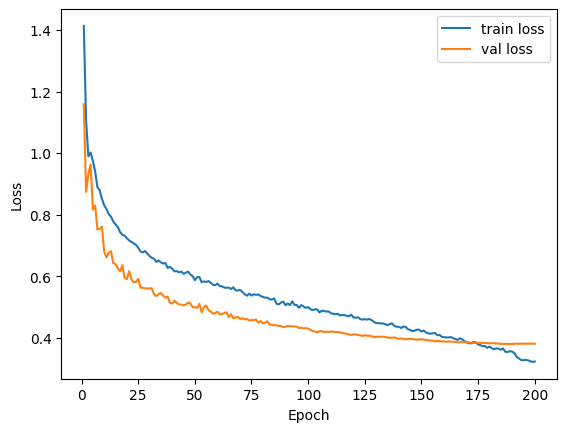

In [11]:
plt.plot(df.epoch, df["train/box_loss"],label='train loss')
plt.plot(df.epoch, df["val/box_loss"],label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Return composite validation metrics

In [13]:
import time
start_time = time.time()

print("-----------------------------------")
print("   Validating on 1000 images to collect metrics")
print("-----------------------------------")

# Validate the model
validation_results = model.val(data=yaml_filename,
                    imgsz=640,  # Image size for validation
                    conf=0.5,  # Confidence threshold
                    iou=0.5,  # IoU threshold
                    device='0')  # Device to use (e.g., '0' for GPU, 'cpu' for CPU)

results = validation_results.results_dict

print("-----------------------------------")
print(results)
print("-----------------------------------")

precision = results['metrics/precision(B)']
recall = results['metrics/recall(B)']
mAP50 = results['metrics/mAP50(B)']
mAP5095 = results['metrics/mAP5095(B)']
fitness = results['fitness']

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"mAP50: {mAP50:.4f}")
print(f"mAP5095: {mAP5095:.4f}")
print(f"Fitness: {fitness:.4f}")

print(f"--- {(time.time() - start_time)} seconds to run---")

-----------------------------------
   Validating on 1000 images to collect metrics
-----------------------------------
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,126,457 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2718.0±1051.1 MB/s, size: 297.1 KB)


val: Scanning /content/fakeplanes/val.cache... 1300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1300/1300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:23<00:00,  1.63it/s]


                   all       1300       7130      0.993      0.954      0.977      0.933
                bomber        722       1128      0.995      0.971      0.985      0.972
               fighter       1131       3204       0.99      0.907      0.954      0.849
                 cargo       1090       2798      0.995      0.984      0.991      0.978
Speed: 0.4ms preprocess, 12.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to fakeplanes_3_class/training_results
-----------------------------------
{'metrics/precision(B)': np.float64(0.9931406271756561), 'metrics/recall(B)': np.float64(0.9537376374018184), 'metrics/mAP50(B)': np.float64(0.9766203835479125), 'metrics/mAP50-95(B)': np.float64(0.933194749967103), 'fitness': np.float64(0.937537313325184)}
-----------------------------------


KeyError: 'metrics/mAP5095(B)'

In [14]:
results

{'metrics/precision(B)': np.float64(0.9931406271756561),
 'metrics/recall(B)': np.float64(0.9537376374018184),
 'metrics/mAP50(B)': np.float64(0.9766203835479125),
 'metrics/mAP50-95(B)': np.float64(0.933194749967103),
 'fitness': np.float64(0.937537313325184)}

Redo predictions with new model

In [15]:
# Path for the trained model
trained_model = 'best.pt'
model_path = os.path.join(base_wdir, project_name, results_folder, 'weights', trained_model)

# Path for the predictions folder
predicts_path = os.path.join(base_wdir, predict_folder)

# Get a list of the different folders in the predict folder
predict_folders = [dir for dir in os.listdir(predicts_path)]

# Image extensions to allow for predictions
image_ext = ['.jpg', '.tif', '.png']

# Initialize model
model = YOLO(model_path)

results = []

for folder in predict_folders:
    folder_path = os.path.join(predicts_path, folder)
    for file in os.listdir(folder_path):
        if file.lower().endswith(tuple(image_ext)):
            file_path = os.path.join(folder_path, file)
            result = model.predict(file_path, visualize=True, conf=0.5, save=True)
            results.append(result[0])

for i in range(len(results)):
    image_output_path = os.path.join(base_wdir, 'three_class_output')  # this is on google drive
    results[i].save(f'{image_output_path}-{trained_model}-{images[i]}')


Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage0_Conv_features.png... (32/80)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage1_Conv_features.png... (32/160)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage2_C2f_features.png... (32/160)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage3_Conv_features.png... (32/320)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage4_C2f_features.png... (32/320)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage5_Conv_features.png... (32/640)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage6_C2f_features.png... (32/640)
Saving runs/detect/predict/Copy of tar_Piedmont_Triad_International_Airport_640_1440_5280/stage7_Conv_features.png

NameError: name 'images' is not defined

Zip the prediction results and download

In [17]:
import shutil
from google.colab import files

# Path to the folder you want to download
folder_path = os.path.join(base_wdir,'runs','detect','predict')  # Change this to your folder path
zip_file_path = '/content/predict_2_results.zip'  # Location where the zip file will be saved

# Create a zip archive of the folder
shutil.make_archive('/content/predict_2_results', 'zip', folder_path)

# Download the zip file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Unused code (ignore)

In [ ]:
import glob

trained_models = 'fakeplanes_3_class' # model & directory name must match


images_path = 'predictions/input/'
# images_path = os.path.join(root_path, "predictions/input_more_images/")  # this is on google drive
images_path = os.path.join(root_path, "predictions/input/")  # this is on google drive
print(images_path)

# The glob pattern is case-sensitive. If your files might have uppercase extension, use '*.JPG' or adjust accordingly.
images = [os.path.basename(file) for file in glob.glob(os.path.join(images_path, '*.jpg'))]
print(images)

model_path = os.path.join(root_path, f"models/{trained_models}.pt")
model = YOLO(model_path)
results = []
for i in range(len(images)):
    image_file = os.path.join(images_path, images[i])
    result = model.predict(image_file, visualize=False, conf=0.5)
    results.append(result[0])

    for res in results:
        # Ensure res is a YOLO results object
        boxes_np = res.boxes.data.cpu().numpy()
        filtered_boxes = boxes_np[np.isin(boxes_np[:, -1], [0, 1, 2])]
        print(filtered_boxes)


for i in range(len(results)):
    # image_output_path = os.path.join(root_path, "predictions/three_class_output/")  # this is on google drive
    image_output_path = os.path.join(root_path, "predictions/output/")  # this is on google drive

    # results[i].save(f'{image_output_path}{trained_models}-{images[i]}')

In [ ]:

# Display each output image inline in Google Colab
for result, image_filename in zip(results, images):
    plt.figure(figsize=(10, 10))
    # Assuming that the `plot()` method returns an image array with predictions drawn
    plt.imshow(result.plot())
    plt.title(f"{trained_models} - {image_filename}")
    plt.axis('off')
    plt.show()

In [ ]:
for res in results:
    # Ensure res is a YOLO results object
    boxes_np = res.boxes.data.cpu().numpy()
    filtered_boxes = boxes_np[np.isin(boxes_np[:, -1], [0, 1, 2])]
    print(filtered_boxes)